**Assignment1 -Parte 2 EuroSAT**

Trabalho realizado por:

Telmo Cunha 2018308321


In [1]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler # Sampler 

Arquitectura do modelo


In [2]:
# Let's build your first CNN model

class nnModel(nn.Module):
  def __init__(self, number_of_classes=1):
    super(nnModel, self).__init__() # NN Module Initialization
    # 1st Convolutional layer
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
    
    # 2nd Convolutional layer
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.pool1 = nn.MaxPool2d(2,2)
    
    #3nd convolutional layer
    self.conv3= nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
    
    #4nd convolutional layer
    self.conv4= nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
    self.pool2 = nn.MaxPool2d(2,2)
    
    #5nd convolutional layer
    self.conv5= nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
    self.pool3 = nn.MaxPool2d(2,2)

    #bacthnormalization(conv)
    self.batch1= nn.BatchNorm2d(16)
    self.batch2= nn.BatchNorm2d(64)
    self.batch3= nn.BatchNorm2d(128)
    self.batch4= nn.BatchNorm2d(256)
    self.batch5= nn.BatchNorm2d(512)

    #bacthnormalization(linear)
    self.batchl1= nn.BatchNorm1d(512)
    self.batchl2= nn.BatchNorm1d(256)
    


    # 1st Fully Connected layer (Linear layer)
    self.fc1 = nn.Linear(in_features=512*8*8, out_features=512)#image size=64,64,3

    # 2nd Fully Connected Layer (linear Layer)
    self.fc2 = nn.Linear(in_features=512 ,out_features=256)

    #3nd fully connected layer
    self.fc3= nn.Linear(in_features=256, out_features=number_of_classes)
    
    # 2nd Fully Connected layer (Linear layer)
    #self.fc4 = nn.Linear(in_features=128, out_features=number_of_classes) # Last layer's output must be the same as the number of classes/categories 
 
    # Dropout
    self.dropout = nn.Dropout(p=0.25)
    

  def forward(self, x):
    # In "forward" function, you define the behaviour of your CNN
    # Activation functions are also implemented in "forward" function
    
    # 1st Convolutional layer
    x = F.relu(self.batch1(self.conv1(x)))
     
    # 2nd Convolutional layer
    x = F.relu(self.batch2(self.conv2(x)))
    x = self.pool1(x)

    #3nd Convolutional layer
    x= F.relu(self.batch3(self.conv3(x)))
    
    #4nd 
    x= F.relu(self.batch4(self.conv4(x)))
    x = self.pool2(x)

    #5nd
    x=F.relu(self.batch5(self.conv5(x)))
    x = self.pool3(x)
    

    # Before passing features to the linear layers, you need to "flatten" the features.
    flat_x = x.view(x.shape[0], -1)

    # 1st Fully Connected layer (Linear layer)
    flat_x = F.relu(self.batchl1(self.fc1(flat_x)))
    

    # 2nd Fully Connected layer (Linear layer)
    flat_x = F.relu(self.batchl2(self.fc2(flat_x))) # Usually, last layer does not need activation layer
    


    #flat_x= F.relu(self.fc3(flat_x))
    

    flat_x = self.dropout(flat_x)#evitar overfitting, aumenta a generalização

    flat_x= self.fc3(flat_x)

    return flat_x

In [3]:
# Check your built CNN model
cnn_model = nnModel(10)
print("CNN Architecture: "+ str(cnn_model))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print('\nThe model will run on', device)
cnn_model = cnn_model.to(device)

# Using the torchsummary, you can check your network in more detail
import torchsummary
print("\n\n")
torchsummary.summary(cnn_model, input_size = (3, 64, 64), batch_size = 5) 


CNN Architecture: nnModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch4): BatchNorm2d(256, eps=1e-05, momentum=

Dataset


In [4]:
from torchvision . datasets import EuroSAT
import torchvision . transforms as tt
import numpy as np

transform_train2= tt.Compose([tt.ToTensor(),
                              tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_train = tt.Compose([tt.ToTensor(),
                              tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #Normalize all the images
                              tt.RandomInvert(0.5),       
                              tt.RandomHorizontalFlip(0.5),       #Flips the image horizontal axis
                              tt.RandomRotation((-45,45))#Rotates the image to a specified angel 
                                                         
                              ])

#tt.ColorJitter(0.2,0.2,0.3,0.3), #brightness, contrast , saturation, hue  
transform = tt.Compose([tt.Resize((32,32)),
                         tt.ToTensor(),
                         tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                       ])

#transform = tt. ToTensor ()
dataset= EuroSAT ( download =True , root ="./ data ",transform = transform_train2 )
dataset2= EuroSAT ( download =True , root ="./ data ",transform = transform_train )
dataset=torch.utils.data.ConcatDataset([dataset,dataset2]);
TrainingSIZE= int(len(dataset)*0.7)
TestingSIZE= int(len(dataset)*0.3)


training_data , testing_data = torch . utils . data . random_split ( dataset , [ TrainingSIZE , TestingSIZE ])
# Lets start to obtain training indices
num_train = len(training_data)
print("Number of images in original training set: " + str(num_train)) # 60 000
indices = list(range(num_train))

# Randomly Shuffle
np.random.shuffle(indices)

# Split 80%/20%
split = int(np.floor(num_train * 0.2)) # 12 000
print("Split Number: " + str(split))
training_idx, valid_idx = indices[split:], indices[:split] # 48 000 / 12 000
print("Number of training images: " + str(len(training_idx)))
print("Number of validation images: " + str(len(valid_idx)))

# Lets also see how many images are on testing set
print("Number of images in the testing set: " + str(len(testing_data))) # 10 000

  0%|          | 0/94280567 [00:00<?, ?it/s]

Extracting ./ data /eurosat/EuroSAT.zip to ./ data /eurosat
Number of images in original training set: 37800
Split Number: 7560
Number of training images: 30240
Number of validation images: 7560
Number of images in the testing set: 16200


In [5]:
# To train the network, you must "encode" the data into a PyTorch dataloader
# Since you divided the original training set in 2, now you need to assign the indices to the samples
training_sampler = SubsetRandomSampler(training_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

batch_size = 128 # 100 images per batch and per epoch

# Training Set
training_loader = torch.utils.data.DataLoader(dataset = training_data, \
                                              batch_size = batch_size, \
                                              sampler = training_sampler)

# Validation Set
valid_loader = torch.utils.data.DataLoader(dataset = training_data, \
                                           batch_size = batch_size, \
                                           sampler = valid_sampler)

# Testing Set
# Here, you do not need the "sampler" input, since you did not change the original testing set
testing_loader = torch.utils.data.DataLoader(dataset = testing_data, \
                                           batch_size = batch_size, \
                                           shuffle = True)
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

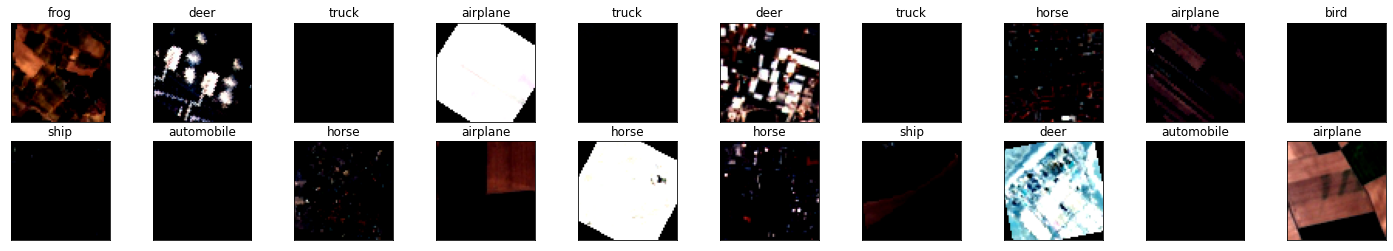

In [6]:
# Visualization of 20 images in a batch
import matplotlib.pyplot as plt
%matplotlib inline

#função para anormalizar e mostar uma imagem
def imshow(img):
  immg= img / 2 + 0.5 #anormalização
  plt.imshow(np.transpose(img, (1, 2, 0))) 

#Get images
data_iter = iter(training_loader)
images, labels = data_iter.next()
images= images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25,4))

#display 20 images
for idx in np.arange(20):
  # Add a subplot for the image
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[] )
  # Subplot with the image
  imshow(images[idx] )
  # print out the correct label for each image
  ax.set_title(classes[labels[idx] ] )

Trainig


In [7]:
# Library imports
import torch.optim as optim
import tensorflow as tf

In [8]:
# To train a CNN, you must choose (or develop) a loss function, an optimizer algorithm, and a set of hyper-parameters (learning rate, number of epochs, etc)
# Hyper-parameters

num_epochs = 20
loss_values = []
lr=0.01  

# Loss Function
criterion = nn.CrossEntropyLoss() # Cross entropy loss function is widely used in classification problems


# Optimizer Algorithm
#optimizer = optim.Adam(cnn_model.parameters(), lr = lr)
optimizer = optim.RAdam(cnn_model.parameters(), lr = lr)
#optimizer =optim.RMSprop(cnn_model.parameters(),lr=lr)

# Training
running_loss = 0.0
training_loss =0.0

y_valid= list()
y_train= list()
#adaptive learning rate
#scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=4,gamma=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='max',factor=0.1,patience=4)

for epoch in range(num_epochs):
  
  for batch_id, data in enumerate(training_loader, 0):
    
    #Get the images and their labels
    images, labels = data
    # Send the images and their labels to the training device
    images, labels = images.to(device), labels.to(device)

    # Pass images through the CNN
    outputs = cnn_model(images)

    # Create a loss value
    loss = criterion(outputs, labels)

    # Backpropagation
    optimizer.zero_grad() # zero the parameter gradients
    loss.backward()
    optimizer.step()

    # Check some statistics
    training_loss+= loss.item()
    running_loss += loss.item()
    if batch_id % 1000 == 999: # prints every 1000 batchs
      print('[%d, %5d] loss: %.3f' % (epoch + 1, batch_id + 1, running_loss / 1000))
      running_loss = 0.0
    
  y_train.append(training_loss/(len(training_idx)/batch_size))
  training_loss=0.0
  
  # For each epoch, analize the model performance
  valid_correct = 0
  valid_total = 0
  valid_total_loss = 0
  with torch.no_grad(): # In this part, you will not train, so you don't need to calculate gradients
    for valid_batch_id, valid_data in enumerate(valid_loader, 0):
      valid_images, valid_labels = valid_data
      valid_images, valid_labels = valid_images.to(device), valid_labels.to(device)
      valid_outputs = cnn_model(valid_images)
      valid_loss = criterion(valid_outputs, valid_labels)
      valid_total_loss += valid_loss.item()
      _, valid_predicted = torch.max(valid_outputs.data, 1)
      valid_total += valid_labels.size(0)
      valid_correct += (valid_predicted == valid_labels).sum().item()
  
  validation_loss= valid_total_loss/len(valid_idx)
  loss_values.append(validation_loss)
  y_valid.append(valid_total_loss/(len(valid_idx)/batch_size))
  print("(Validation Set) Epoch: " + str(epoch + 1) + " Loss: " + str(valid_total_loss/ len(valid_idx)) + " Acc: " + str(100*valid_correct/valid_total))
  print('Epoch-{0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))
  scheduler.step(loss)


print("Training is completed!")

(Validation Set) Epoch: 1 Loss: 0.006423179576636622 Acc: 70.84656084656085
Epoch-0 lr: 0.01
(Validation Set) Epoch: 2 Loss: 0.005482130675088791 Acc: 76.04497354497354
Epoch-1 lr: 0.01
(Validation Set) Epoch: 3 Loss: 0.004889312969944465 Acc: 77.5925925925926
Epoch-2 lr: 0.01
(Validation Set) Epoch: 4 Loss: 0.004210960506289094 Acc: 82.75132275132275
Epoch-3 lr: 0.01
(Validation Set) Epoch: 5 Loss: 0.003646299948610326 Acc: 83.9021164021164
Epoch-4 lr: 0.01
(Validation Set) Epoch: 6 Loss: 0.003342067247266492 Acc: 85.78042328042328
Epoch-5 lr: 0.01
(Validation Set) Epoch: 7 Loss: 0.0021882913533657314 Acc: 90.91269841269842
Epoch-6 lr: 0.001
(Validation Set) Epoch: 8 Loss: 0.0020205114253614314 Acc: 92.12962962962963
Epoch-7 lr: 0.001
(Validation Set) Epoch: 9 Loss: 0.001816648632169716 Acc: 92.22222222222223
Epoch-8 lr: 0.001
(Validation Set) Epoch: 10 Loss: 0.0018654467094512213 Acc: 92.36772486772487
Epoch-9 lr: 0.001
(Validation Set) Epoch: 11 Loss: 0.001520688907691726 Acc: 93.39

Loss per epoch

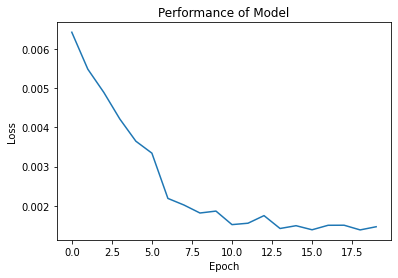

In [9]:
plt.plot(loss_values)
plt.xlabel ("Epoch")
plt.ylabel ("Loss")
plt.title ("Performance of Model")
plt.show()

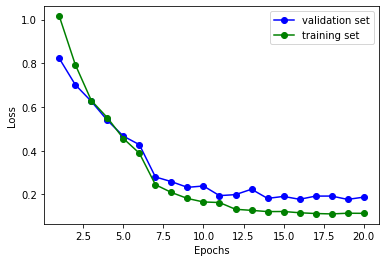

In [10]:
# plot  
x = list(range(1, num_epochs+1))
plt.plot(x, y_valid, 'bo-', label ='validation set')
plt.plot(x, y_train, 'go-', label ='training set')

plt.xlabel("Epochs")
plt.ylabel("Loss")
  
# Function add a legend  
plt.legend()
  
# function to show the plot
plt.show()

Testing

Accuracy using 16200 test images: 94.51234567901234 %

Accuracy of  0 : 93 % in 1713 Images
Accuracy of  1 : 98 % in 1823 Images
Accuracy of  2 : 91 % in 1835 Images
Accuracy of  3 : 92 % in 1494 Images
Accuracy of  4 : 95 % in 1469 Images
Accuracy of  5 : 93 % in 1219 Images
Accuracy of  6 : 91 % in 1501 Images
Accuracy of  7 : 97 % in 1771 Images
Accuracy of  8 : 91 % in 1544 Images
Accuracy of  9 : 98 % in 1831 Images

Confusion Matrix
[[1602    0   11   14    0   13   26    0   35   13]
 [   5 1788   11    1    0    4    0    0    6    6]
 [   9   11 1671    9    4   27   61   13   11    0]
 [   6    0    8 1389   23    1   11    2   47    1]
 [   0    0    4   20 1407    0    8   17    2    0]
 [  35   19   12    2    0 1144   17    0   19    6]
 [  29    0   91   14   15   17 1371    5   12    0]
 [   0    1   19    4   17    0    0 1734    0    0]
 [  16    1    7   41    3   10    7    0 1409    9]
 [  11    3    1    0    0    3    0    0    3 1796]]




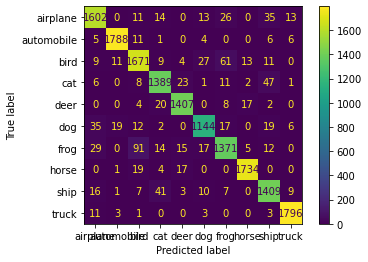


Global F1 score:93.05555555555556
Mean F1 score:93.17409442409443
Mean precision:94.62542087542087
Mean recall 93.05555555555556


In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import ConfusionMatrixDisplay
# Evaluate a CNN is similar to the training process without the backpropagation.
# To evaluate a CNN, we need to follow the evaluation metrics
num_classes = 10
correct = 0
total = 0
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))
conf_matrix =[[0 for x in range(num_classes)] for y in range(num_classes)]

cnn_model.eval()

with torch.no_grad(): # You are not training, so you don't need to calculate gradients
  for batch_id, data in enumerate(testing_loader, 0):
    # Get the images and their labels
    images, labels = data
    # Send the images and their labels to the training device
    images, labels = images.to(device), labels.to(device)

    # Calculate the CNN's predictions by running images through the network
    outputs = cnn_model(images)

    # The class with the highest
    _, predicted = torch.max(outputs.data, 1)

    # Get model's performance
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    c = (predicted == labels).squeeze()

    for i in range(len(images)):  
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1

    conf_matrix += confusion_matrix(predicted.cpu(),labels.cpu(),labels=[x for x in range(num_classes)])

# Show model's performance
print('Accuracy using {} test images: {} %\n'.format(total,100 * correct / total))
# Performance per Class
for i in range(num_classes):
  if class_total[i] == 0:
    print('Accuracy of %2s : %2d %% in %d Images' % (i, 0, 0))
  else:
    print('Accuracy of %2s : %2d %% in %d Images' % (i, 100 * class_correct[i] / class_total[i], class_total[i]))

# Confusion Matrix
print('\nConfusion Matrix')
print(conf_matrix) 

print('\n')
conf_disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, 
                       display_labels = classes)
conf_disp.plot()
plt.show()

f1micro = f1_score(labels.cpu(),predicted.cpu(),average="micro")
f1mean = f1_score(labels.cpu(),predicted.cpu(),average="weighted")
precision=precision_score(labels.cpu(),predicted.cpu(),average="weighted")
recall=recall_score(labels.cpu(),predicted.cpu(),average="weighted")


print("\nGlobal F1 score:"+str(f1micro*100))
print("Mean F1 score:"+str(f1mean*100))
print("Mean precision:"+str(precision*100))
print("Mean recall", str(recall*100))
